# <font color="RoyalBlue">Energy Price Prediction - Introduction</font>

This project is part of a university course and focuses on <b>predicting electricity prices</b> using Python and Jupyter Notebooks. For now, only the hourly <b>EPEX SPOT day-ahead prices of germany</b> are covered. After a quick data analysis, several machine learning and time series models (SARIMA, Prophet, XGBoost, LSTM) are trained, evaluated and finally compared.

Table of Contents of this Notebook:
1) Importing Libraries
2) Loading the Data
3) Merging the Data Frames
4) Exploratory Data Analysis (EDA)
5) Data Preparation
6) Feature Engineering
7) Model Training and Prediction
8) Model Evaluation and Comparison
9) Conclusion

## <font color="RoyalBlue">1 Importing Libraries</font>
First of all, we import all necessary libraries required for data analysis, machine learning models and data visualization. This is also where we can set a plot design that will be applied for Seaborn and Pyplot.

In [1]:
# General
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning & Time Series Models
from xgboost import XGBRegressor
import xgboost as xgb
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Scikit-Learn Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Holidays
import holidays

# Time and Date
import datetime

# Simple plot design
print(plt.style.available)
sns.set_style('darkgrid')
sns.set_palette("bright")


['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## <font color="RoyalBlue">2 Loading the Data</font>

After importing all libraries, let's load the data of the csv files into this project. We use several csv files and later merge them together into just one dataframe by using their date and hour column as a primary key. Before merging, we take a brief look at each data frame and remove unnecessary information. Moreover, we need to overcome some challenges, such as converting data types and handling the german daylight saving time change.

The first data set contains the hourly EPEX Spot prices and looks as follows:


In [2]:
df_prices = pd.read_csv("../data/germany_epex_spot.csv")

# Print data types and first five rows
print(df_prices.dtypes)
df_prices.head()

Country              object
ISO3 Code            object
Datetime (UTC)       object
Datetime (Local)     object
Price (EUR/MWhe)    float64
dtype: object


,Country,ISO3 Code,Datetime (UTC),Datetime (Local),Price (EUR/MWhe)
0,Germany,DEU,2015-01-01 00:00:00,2015-01-01 01:00:00,22.34
1,Germany,DEU,2015-01-01 01:00:00,2015-01-01 02:00:00,22.34
2,Germany,DEU,2015-01-01 02:00:00,2015-01-01 03:00:00,22.34
3,Germany,DEU,2015-01-01 03:00:00,2015-01-01 04:00:00,22.34
4,Germany,DEU,2015-01-01 04:00:00,2015-01-01 05:00:00,22.34


We can obviously remove the columns "Country", "ISO3 Code" and "Datetime (UTC)" because they wont be needed for the model training. With regard to merging the individual dataframes later, we will also rename the time-related column that represent our primary key to "timestamp". Furthermore, we need to convert this timestamp into a valid datetime type. Because the decimal numbers in the price column have already been in a valid float number format, we do not need to adjust anything here.

In [3]:
# Rename important Columns to snake case format
df_prices = df_prices.rename(columns={
    'Datetime (Local)': 'timestamp',
    'Price (EUR/MWhe)': 'price_eur_per_mwh'
})

# Only keep relevant Columns
df_prices = df_prices[['timestamp', 'price_eur_per_mwh']]

# Convert data type from string to datetime64[ns]
df_prices['timestamp'] = pd.to_datetime(df_prices['timestamp'])

# Print data types and first five rows again
print(df_prices.dtypes)
df_prices.head()

timestamp            datetime64[ns]
price_eur_per_mwh           float64
dtype: object


,timestamp,price_eur_per_mwh
0,2015-01-01 01:00:00,22.34
1,2015-01-01 02:00:00,22.34
2,2015-01-01 03:00:00,22.34
3,2015-01-01 04:00:00,22.34
4,2015-01-01 05:00:00,22.34


The next data set contains information about the energy consumption and includes hourly forecasts for the demand of net load and residual load. The net load represents the total electricity demand at a given time, including all consumers. The residual load refers the the remaining electricity demand that must be met by controllable power plants after subtracting generation from renewable sources like wind and solar. The dataframe looks like this:

In [4]:
df_consumption = pd.read_csv("../data/energy_consumption_forecast.csv", delimiter=";", na_values="-")

# Print data types and first five rows
print(df_consumption.dtypes)
df_consumption.head()

Date from                       object
Date to                         object
Forecast Netload[MWh]          float64
Forecast Residual Load[MWh]    float64
dtype: object


,Date from,Date to,Forecast Netload[MWh],Forecast Residual Load[MWh]
0,01.01.2015 00:00,01.01.2015 01:00,49306.25,41399.00
1,01.01.2015 01:00,01.01.2015 02:00,46952.50,38481.50
2,01.01.2015 02:00,01.01.2015 03:00,45751.50,37152.25
3,01.01.2015 03:00,01.01.2015 04:00,45306.25,36638.50
4,01.01.2015 04:00,01.01.2015 05:00,45423.00,36580.50


Just like with the first dataframe, we can remove unnecessary columns and rename others. Because the decimal numbers inside our date are stored in a german floating point format, we need to convert these decimal values into the correct format so that we can work with actual float64 values. Also note, that the loaded csv files data uses a single "-" symbol in order to implicate NaN values. However, this was already taken care of by the parameter *na_values* of the *load_csv* function.

In [5]:
# Rename important columns to snake case format
df_consumption = df_consumption.rename(columns={
    'Date from': 'timestamp',
    'Forecast Netload[MWh]': 'forecast_net_load_mwh',
    'Forecast Residual Load[MWh]': 'forecast_residual_load_mwh'
})

# Get rid of unnecessary "Date to" column
df_consumption.drop(columns=['Date to'], inplace=True)

# Convert data type from string to datetime64[ns]
df_consumption['timestamp'] = pd.to_datetime(df_consumption['timestamp'], format="%d.%m.%Y %H:%M")

# Print data types and first five rows again
print(df_consumption.dtypes)
df_consumption.head()

timestamp                     datetime64[ns]
forecast_net_load_mwh                float64
forecast_residual_load_mwh           float64
dtype: object


,timestamp,forecast_net_load_mwh,forecast_residual_load_mwh
0,2015-01-01 00:00:00,49306.25,41399.00
1,2015-01-01 01:00:00,46952.50,38481.50
2,2015-01-01 02:00:00,45751.50,37152.25
3,2015-01-01 03:00:00,45306.25,36638.50
4,2015-01-01 04:00:00,45423.00,36580.50


Finally, we will also use data containing hourly forecasts for energy generation. These include forecasts on solar and wind energy generation as well as "others", meaning all remaning energy sources that have not been explicitly stated in other columns, such as biomass, hydropower, nuclear, coal and gas.

In [6]:
df_generation = pd.read_csv("../data/power_generation_forecast.csv", delimiter=";", na_values="-")

# Print data types and first five rows
print(df_generation.dtypes)
df_generation.head()

Date from                         object
Date until                        object
Forecast Total [MWh]             float64
Forecast Wind and Solar [MWh]    float64
Forecast Wind Offshore [MWh]     float64
Forecast Wind Onshore [MWh]      float64
Forecast Solar [MWh]             float64
Forecast Other Sources [MWh]     float64
dtype: object


,Date from,Date until,Forecast Total [MWh],Forecast Wind and Solar [MWh],Forecast Wind Offshore [MWh],Forecast Wind Onshore [MWh],Forecast Solar [MWh],Forecast Other Sources [MWh]
0,01.01.2015 00:00,01.01.2015 01:00,58974.0,7907.25,258.50,7648.75,0.0,51066.75
1,01.01.2015 01:00,01.01.2015 02:00,57681.0,8471.00,258.75,8212.25,0.0,49210.00
2,01.01.2015 02:00,01.01.2015 03:00,56256.0,8599.25,258.50,8340.75,0.0,47656.75
3,01.01.2015 03:00,01.01.2015 04:00,54432.0,8667.75,259.00,8408.75,0.0,45764.25
4,01.01.2015 04:00,01.01.2015 05:00,54522.0,8842.50,260.50,8582.00,0.0,45679.50


Just like before, there is some work to do, including the removal and renaming of some columns as well as converting data types.

In [7]:
# Remove unnecessary Columns
df_generation = df_generation.drop(columns=[
    "Date until",
    "Forecast Wind and Solar [MWh]"
])

# Rename important columns to snake case format
df_generation = df_generation.rename(columns={
    'Date from': 'timestamp',
    'Forecast Total [MWh]': 'forecast_total_mwh',
    'Forecast Wind Offshore [MWh]': 'forecast_wind_offshore_mwh',
    'Forecast Wind Onshore [MWh]': 'forecast_wind_onshore_mwh',
    'Forecast Solar [MWh]': 'forecast_solar_mwh',
    'Forecast Other Sources [MWh]': 'forecast_other_mwh'
})

# Convert timstamp to datetime type
df_generation['timestamp'] = pd.to_datetime(df_generation['timestamp'], format="%d.%m.%Y %H:%M")

# Print data types and first five rows again
print(df_generation.dtypes)
df_generation.head()

timestamp                     datetime64[ns]
forecast_total_mwh                   float64
forecast_wind_offshore_mwh           float64
forecast_wind_onshore_mwh            float64
forecast_solar_mwh                   float64
forecast_other_mwh                   float64
dtype: object


,timestamp,forecast_total_mwh,forecast_wind_offshore_mwh,forecast_wind_onshore_mwh,forecast_solar_mwh,forecast_other_mwh
0,2015-01-01 00:00:00,58974.0,258.50,7648.75,0.0,51066.75
1,2015-01-01 01:00:00,57681.0,258.75,8212.25,0.0,49210.00
2,2015-01-01 02:00:00,56256.0,258.50,8340.75,0.0,47656.75
3,2015-01-01 03:00:00,54432.0,259.00,8408.75,0.0,45764.25
4,2015-01-01 04:00:00,54522.0,260.50,8582.00,0.0,45679.50


## <font color="RoyalBlue">3 Merging the Data Frames</font>

After loading in the data, creating our dataframes and preparing them, we are now theoretically ready to merge them together into just one single dataframe. However, before that, make sure that each dataframes timestamp column is valid to be merged on. We'll see that this is not the case right now!

In [8]:
# Make sure that we have a common timestamp column
common_columns = set(df_generation.columns).intersection(df_consumption.columns).intersection(df_prices.columns)
print("Common columns between all dataframes:", common_columns)

# Let's also make sure that the data type of each timestamp is valid
print("Data type df_prices['timestamp']:", df_prices['timestamp'].dtype)
print("Data type df_generation['timestamp']:", df_generation['timestamp'].dtype)
print("Data type df_consumption['timestamp']:", df_consumption['timestamp'].dtype)

# Check if timestamp is NaN anywhere
print("df_prices has {} timestamp values that are NaN".format(df_prices['timestamp'].isna().sum()))
print("df_generation has {} timestamp values that are NaN".format(df_generation['timestamp'].isna().sum()))
print("df_consumption has {} timestamp values that are NaN".format(df_consumption['timestamp'].isna().sum()))

# Print the amount of common timestamp values
common_values = set(df_generation['timestamp']).intersection(df_consumption['timestamp']).intersection(df_prices['timestamp'])
print("Common values between all dataframes:", len(common_values))

# Check for any timestamp duplicates -> Daylight Saving Time Change!?
print(df_prices[df_prices.duplicated(subset='timestamp')])
print(df_generation[df_generation.duplicated(subset='timestamp')])
print(df_consumption[df_consumption.duplicated(subset='timestamp')])


Common columns between all dataframes: {'timestamp'}
Data type df_prices['timestamp']: datetime64[ns]
Data type df_generation['timestamp']: datetime64[ns]
Data type df_consumption['timestamp']: datetime64[ns]
df_prices has 0 timestamp values that are NaN
df_generation has 0 timestamp values that are NaN
df_consumption has 0 timestamp values that are NaN
Common values between all dataframes: 87661
                timestamp  price_eur_per_mwh
7129  2015-10-25 02:00:00              25.02
16033 2016-10-30 02:00:00              31.55
24769 2017-10-29 02:00:00             -83.00
33505 2018-10-28 02:00:00              44.06
42241 2019-10-27 02:00:00             -10.38
50977 2020-10-25 02:00:00              -6.39
59881 2021-10-31 02:00:00              58.26
68617 2022-10-30 02:00:00              95.29
77353 2023-10-29 02:00:00               7.58
86089 2024-10-27 02:00:00              68.62
                timestamp  forecast_total_mwh  forecast_wind_offshore_mwh  \
7130  2015-10-25 02:00:00   

### Note on Duplicate Timestamps (Daylight Saving Time)

As seen above, the datasets contain exactly one duplicate timestamp at Hour 02:00 on the last Sunday of October every year. This occurs due to the end of Daylight Saving Time in Germany, when clocks are set back one hour. As a result, the hour between 02:00 and 03:00 appears twice. These duplicate timestamps need to be handled accordingly, for example by using timezone-aware timestamps, removing duplicates, or differentiating them manually. For this project, it is sufficient to just remove these "duplicates".

In [9]:
# Remove duplicates that result from daylight saving time
df_prices = df_prices[~df_prices.duplicated(subset='timestamp')]
df_generation = df_generation[~df_generation.duplicated(subset='timestamp')]
df_consumption = df_consumption[~df_consumption.duplicated(subset='timestamp')]

# Check if there are duplicates left
print("Amount of duplicates in df_prices:", df_prices['timestamp'].duplicated().sum())
print("Amount of duplicates in df_generation:", df_generation['timestamp'].duplicated().sum())
print("Amount of duplicates in df_consumption:", df_consumption['timestamp'].duplicated().sum())

Amount of duplicates in df_prices: 0
Amount of duplicates in df_generation: 0
Amount of duplicates in df_consumption: 0


We are now ready to merge all dataframes into one and set the index to timestamp:

In [10]:
# Now merge the dataframes
df = pd.merge(
    df_prices,
    df_consumption,
    on='timestamp',
    how='inner'
)

df = pd.merge(
    df,
    df_generation,
    on='timestamp',
    how='inner'
)

# Set timetamp as index
df = df.set_index("timestamp")
df = df.sort_index()

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87661 entries, 2015-01-01 01:00:00 to 2024-12-31 23:00:00
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   price_eur_per_mwh           87661 non-null  float64
 1   forecast_net_load_mwh       86362 non-null  float64
 2   forecast_residual_load_mwh  86338 non-null  float64
 3   forecast_total_mwh          87589 non-null  float64
 4   forecast_wind_offshore_mwh  87637 non-null  float64
 5   forecast_wind_onshore_mwh   87659 non-null  float64
 6   forecast_solar_mwh          87659 non-null  float64
 7   forecast_other_mwh          87565 non-null  float64
dtypes: float64(8)
memory usage: 6.0 MB


It is best to quickly check if the merge was valid. This is because even if the merge runs without errors, issues like misaligned timestamps, unexpected duplicates, or missing data can lead to incorrect results or inconsistencies in the dataset.  

In [11]:
# Check if merge is valid
common_timestamps = set(df_prices['timestamp']) & set(df_consumption['timestamp']) & set(df_generation['timestamp'])
print("Expected number of rows:", len(common_timestamps))
print("Actual number of rows:", len(df))

# Check for missing values in each column
print("\nAmount of missing values per column:")
print(df.isna().sum())

# Check the data types
print("\nData types:", df.dtypes)

df.head()

Expected number of rows: 87661
Actual number of rows: 87661

Amount of missing values per column:
price_eur_per_mwh                0
forecast_net_load_mwh         1299
forecast_residual_load_mwh    1323
forecast_total_mwh              72
forecast_wind_offshore_mwh      24
forecast_wind_onshore_mwh        2
forecast_solar_mwh               2
forecast_other_mwh              96
dtype: int64

Data types: price_eur_per_mwh             float64
forecast_net_load_mwh         float64
forecast_residual_load_mwh    float64
forecast_total_mwh            float64
forecast_wind_offshore_mwh    float64
forecast_wind_onshore_mwh     float64
forecast_solar_mwh            float64
forecast_other_mwh            float64
dtype: object


,price_eur_per_mwh,forecast_net_load_mwh,forecast_residual_load_mwh,forecast_total_mwh,forecast_wind_offshore_mwh,forecast_wind_onshore_mwh,forecast_solar_mwh,forecast_other_mwh
timestamp,,,,,,,,
2015-01-01 01:00:00,22.34,46952.50,38481.50,57681.0,258.75,8212.25,0.0,49210.00
2015-01-01 02:00:00,22.34,45751.50,37152.25,56256.0,258.50,8340.75,0.0,47656.75
2015-01-01 03:00:00,22.34,45306.25,36638.50,54432.0,259.00,8408.75,0.0,45764.25
2015-01-01 04:00:00,22.34,45423.00,36580.50,54522.0,260.50,8582.00,0.0,45679.50
2015-01-01 05:00:00,22.34,45701.50,36694.75,53811.0,262.00,8744.75,0.0,44804.25


Now it's time to add some more features and lags to our dataframe

<Axes: title={'center': 'Data Frame'}, xlabel='timestamp'>

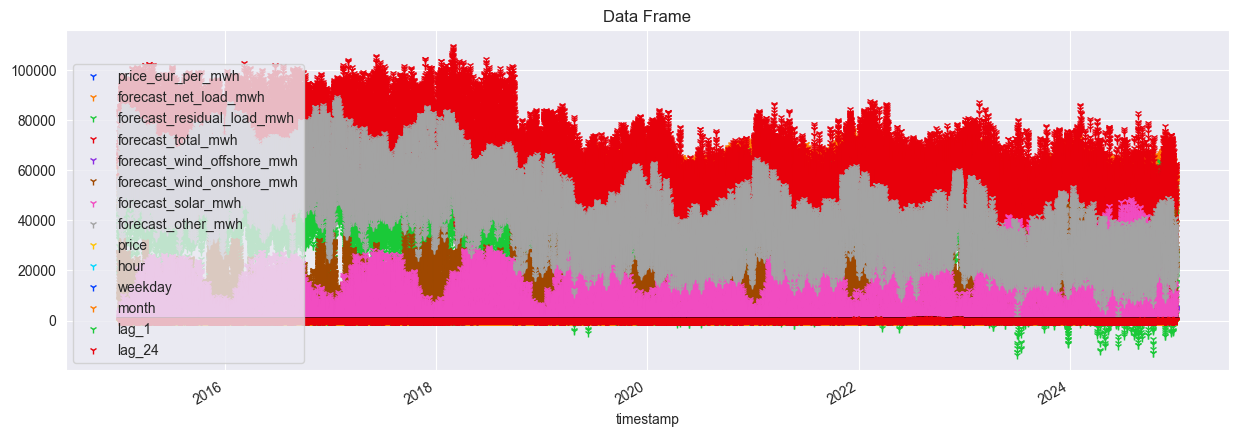

In [12]:
# TODO: overhaul all of this

# convert local time in datetime object and set as index
# df_prices["timestamp"] = pd.to_datetime(df_prices["timestamp"])
# df_prices = df_prices.set_index("timestamp")
# df_prices = df_prices.sort_index()

# target variable
df["price"] = df["price_eur_per_mwh"]

# time based features
df["hour"] = df.index.hour
df["weekday"] = df.index.weekday
df["month"] = df.index.month

# lag features (price 1h and 24h before)
df["lag_1"] = df["price"].shift(1)
df["lag_24"] = df["price"].shift(24)
# TODO: maybe more? What is best?

df.plot(style="1", figsize=(15, 5), title="Data Frame")


Print out some basic information about our data

In [13]:
# df.head()
# df.tail()
# df.describe()
df.dtypes
# df.info()
# df.shape()
# df.count()
# df.min()
# df.max()

# TODO: do this for all our data frames when new data sets are available

price_eur_per_mwh             float64
forecast_net_load_mwh         float64
forecast_residual_load_mwh    float64
forecast_total_mwh            float64
forecast_wind_offshore_mwh    float64
forecast_wind_onshore_mwh     float64
forecast_solar_mwh            float64
forecast_other_mwh            float64
price                         float64
hour                            int32
weekday                         int32
month                           int32
lag_1                         float64
lag_24                        float64
dtype: object

TODO: explain negative electricity prices very briefly here and print some examples

## <font color="RoyalBlue">3 Exploratory Data Analysis (EDA)</font>
In this section, we explore and visualize the data to better understand patterns and correlation. This is done before handling NaN values and outliers.

TODO: add small summary for each plot
- Price over Time
- Correlation of the featuers (maybe with sns.heatmap)
- Plot and explain seasonal patterns
- Plot the target variable over time
- Boxplot
- more ... ?

### Price over Time

In [14]:
# TODO: plot price over time

### Correlation of the features

In [15]:
# TODO: sns.heatmap()

## <font color="RoyalBlue">4 Data Preparation</font>
This section prepares the data by handling missing values, removing duplicates and transforming data types (TODO: remove last part of sentence if no transformation needed later). This is also a good place to remove unnecessary features that may have a negative impact on the models prediction.

In [16]:
# remove rows with NaN (because of shift)

nan_amount_before = 20 # TODO -> df.isna().sum()
print("amount of NaN values before cleanup: {}".format(nan_amount_before))
df_prices = df_prices.dropna()
nan_amount_after = 0 # TODO
print("amount of NaN values after cleanup: {}".format(nan_amount_after))

nan_amount_removed = nan_amount_before - nan_amount_after
print("So we removed {} NaN values".format(nan_amount_removed))


amount of NaN values before cleanup: 20
amount of NaN values after cleanup: 0
So we removed 20 NaN values


TODO: maybe scaling / normalising needed for numerical features?

In [17]:
# TODO: scale or normalize values if this achieves better performance

## <font color="RoyalBlue">5 Feature Engineering</font>
Here, we can use our conclusions of the EDA by defining our feature set and the target variable that is to predict. In this regard, we will also create some new features that can be used for training in order to gain a better performance out of the models.

Lastly, we split our data into train and test data. Note, that when using time series data like we do, we should not split randomly, but by date instead.

TODO: maybe explain the term "lags"

In [18]:
# Create some new features

# TODO: calendar features (hour, weekday, month)
# TODO: add holiday features

In [19]:
# Define feature set and target variable 
features = ["hour", "weekday", "month", "lag_1", "lag_24"] # lags used for 
X = df[features]
y = df["price"]

Now we split our data into train and test data. We need to make sure that the data is not split randomly, but instead chronologically, so that the model is trained on past data and tested on future data only. This avoids so called "Data Leakage".

In this case, we split by 80:20 for Training and Test data.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

# For X_train
print("X_train:")
print("  Lines:", len(X_train))
print("  Span:", X_train.index.min(), "until", X_train.index.max())

# For X_test
print("X_test:")
print("  Lines:", len(X_test))
print("  Span:", X_test.index.min(), "Span", X_test.index.max())

# For y_train
print("y_train:")
print("  Lines:", len(y_train))
print("  Span:", y_train.index.min(), "Span", y_train.index.max())

# For y_test
print("y_test:")
print("  Lines:", len(y_test))
print("  Span:", y_test.index.min(), "Span", y_test.index.max())

X_train:
  Lines: 70128
  Span: 2015-01-01 01:00:00 until 2023-01-01 08:00:00
X_test:
  Lines: 17533
  Span: 2023-01-01 09:00:00 Span 2024-12-31 23:00:00
y_train:
  Lines: 70128
  Span: 2015-01-01 01:00:00 Span 2023-01-01 08:00:00
y_test:
  Lines: 17533
  Span: 2023-01-01 09:00:00 Span 2024-12-31 23:00:00


## <font color="RoyalBlue">6 Model Training and Prediction</font>
In this section, we ... TODO

TODO: use different data for each model (SARIMA, Prophet, XGBoost, LSTM)?

TODO: add a section for each model

### Create and train model (only XGBRegressor for now)

In [21]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

### Predict and evaluate

In [22]:
y_pred = model.predict(X_test)

# TODO: do evaluation in section 7 below 
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse:.2f} EUR/MWh")

RMSE: 13.00 EUR/MWh


## <font color="RoyalBlue">7 Model Evaluation and Comparison</font>
TODO: add description

Plot real prices against the predicted prices for each model (probably best to do this in one plot only)

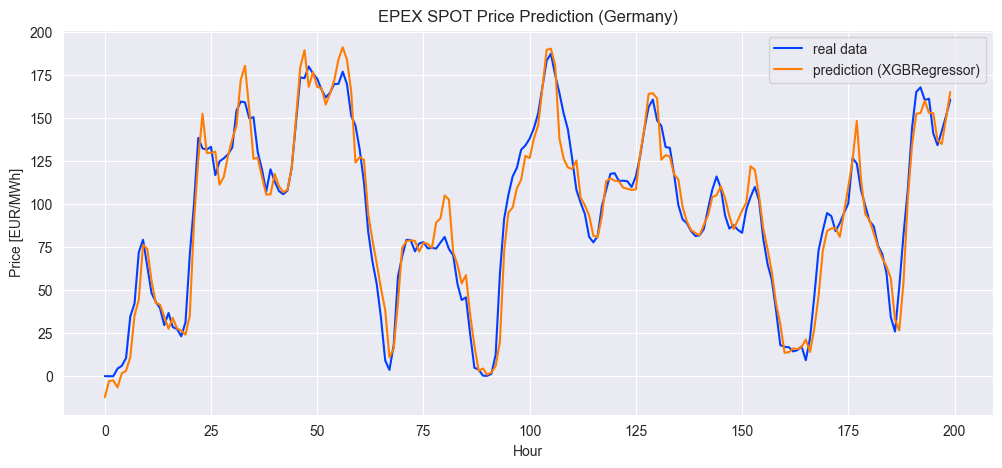

In [23]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.values[:200], label="real data")
plt.plot(y_pred[:200], label="prediction (XGBRegressor)")
plt.legend()
plt.title("EPEX SPOT Price Prediction (Germany)")
plt.xlabel("Hour")
plt.ylabel("Price [EUR/MWh]")
plt.show()

TODO: Print relevant evaluation metrics for eacht model (MAE, RMSE, MAPE) and explain them briefly.


## <font color="RoyalBlue">8 Conclusion</font>
TODO: add:
- which model performs the best? Why? 
- What errors / short cuts may have been made in this project? How does it impact the outcome?
- do certain models show specific weaknesses (for example especially bad predictions on holidays)